# Checkpoint 1

Importowanie bibliotek.

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dateutil import parser
from datetime import date
from collections import Counter
from decimal import *

Wczytywanie danych.

In [2]:
gb_videos_raw = pd.read_csv("data/GB_videos_5p.csv", sep=';')
gb_category = pd.read_json("data/GB_category_id.json")
us_videos_raw = pd.read_csv("data/US_videos_5p.csv", sep=';')
us_category = pd.read_json("data/US_category_id.json")

Wstępne przetwarzanie danych

In [3]:
gb_videos_raw = gb_videos_raw[gb_videos_raw["video_id"]!="#NAZWA?"]
us_videos_raw = us_videos_raw[us_videos_raw["video_id"]!="#NAZWA?"]

In [4]:
gb_count = gb_videos_raw[["video_id", "trending_date"]].groupby(['video_id']).count()
us_count = us_videos_raw[["video_id", "trending_date"]].groupby(['video_id']).count()
gb_videos_raw = gb_videos_raw.groupby(['video_id']).last()
us_videos_raw = us_videos_raw.groupby(['video_id']).last()
gb_videos_raw["upload_time"] = gb_count
us_videos_raw["upload_time"] = us_count

In [5]:
def change_date_format(df):
    data = df["trending_date"]
    data = data.split('.')
    data = list(map(int, data))
    if data[0] < 2000:
        data[0] += 2000
    return date(data[0], data[2], data[1])

def calculate_date_delta(df):
    trending = df["trending_date"]
    publish = parser.isoparse(df["publish_time"]).date()

    return (trending - publish).days

gb_videos = gb_videos_raw.copy()
us_videos = us_videos_raw.copy()

gb_videos["trending_date"] = gb_videos.apply(lambda row: change_date_format(row), axis=1)
us_videos["trending_date"] = us_videos.apply(lambda row: change_date_format(row), axis=1)

gb_videos["publish_to_trending_time"] = gb_videos.apply(lambda row: calculate_date_delta(row), axis=1)
us_videos["publish_to_trending_time"] = us_videos.apply(lambda row: calculate_date_delta(row), axis=1)

## Wstępne statystyki

Funkcje pomocnicze

In [6]:
def display_histogram(df, column_name, bins=10):
    count, division = np.histogram(df[column_name], bins=bins)

    count = [[x, f"{x / df.shape[0]:.5%}"] for x in count]
    count_range = range(len(count))

    division = [[f"{Decimal(division[i]):.2E}", f"{Decimal(division[i + 1]):.2E}"] for i in range(len(division) - 1)]
    division_range = range(len(division))

    fig, ax = plt.subplots(1, 3, figsize=(18,5))

    # Graph
    ax[0].hist(x=df[column_name], bins=bins)

    # Counts
    font_size=14
    bbox=[0, 0, 1, 1]
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = count, rowLabels = count_range, bbox=bbox, colLabels=["Count", "Percentage"])
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    # Ranges
    font_size=14
    bbox=[0, 0, 1, 1]
    ax[2].axis('off')
    mpl_table = ax[2].table(cellText = division, rowLabels = division_range, bbox=bbox, colLabels=["Range from", "Range to"])
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

### Filmy z UK

#### Wyświetlenia

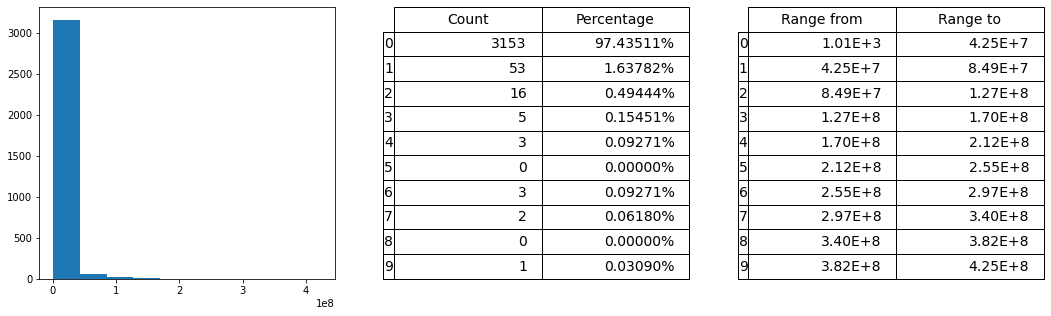

In [7]:
display_histogram(gb_videos, "views")

Na przedstawionym wyżej histogramie widać, że zdecydowana większość filmików ma mniej niż 42.5 miliona wyświetleń.


#### Polubienia i negatywne oceny

##### Polubienia

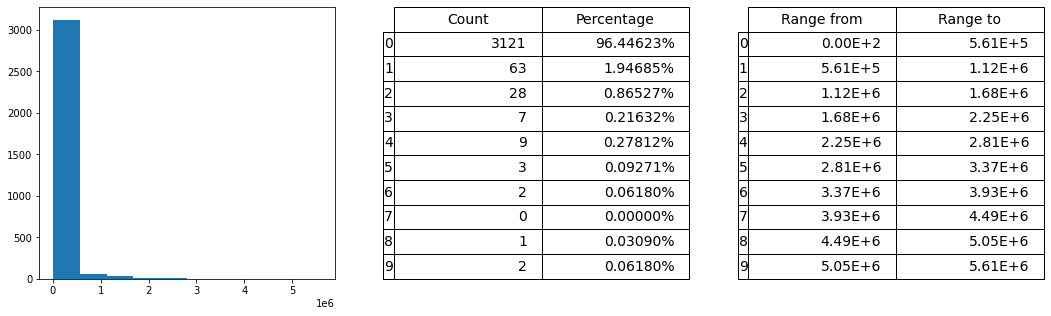

In [8]:
display_histogram(gb_videos, "likes")

Większość filmików, podobnie jak w przypadku histogramu wyświetleń, trafia do pierwszego przedziału histogramu polubień - prawie 95% filmików ma mniej niż około 561 tysięcy polubień. Jest to najprawdopodobniej spowodowane przez rozkład wyświetleń filmików i mechanizm pozostawiania pozytywnej oceny. Aby ocenić filmik należy w niego wejść zwiększając tym samym liczbę wyświetleń. Sprawia to, że polubienia nigdy nie przekroczą liczby wyświetleń.

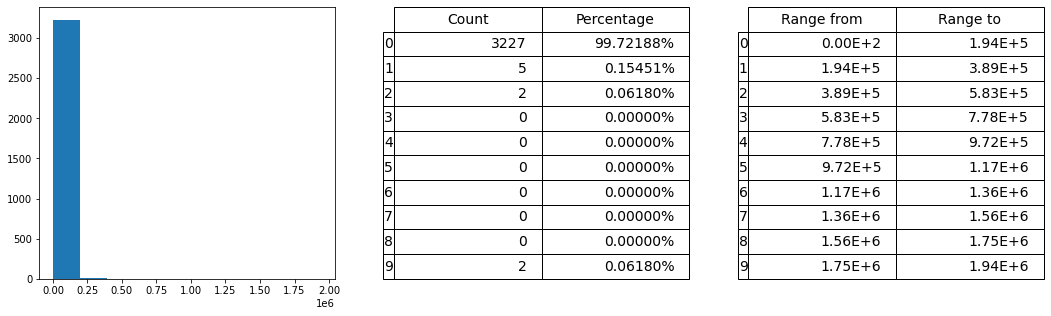

In [9]:
display_histogram(gb_videos, "dislikes")

W przypadku negatywnych ocen otrzymany histogram jest jeszcze bardziej skupiony w pierwszym przedziale - ponad 99% filmików ma mniej niż 194 tysiące negatywnych ocen. Przyczyny takiego rozkładu są prawdopodobnie identyczne jak dla polubień, czyli wpływ na ten histogram mają rozkład wyświetleń filmików i mechanizm pozostawiania oceny.

#### Liczba komentarzy

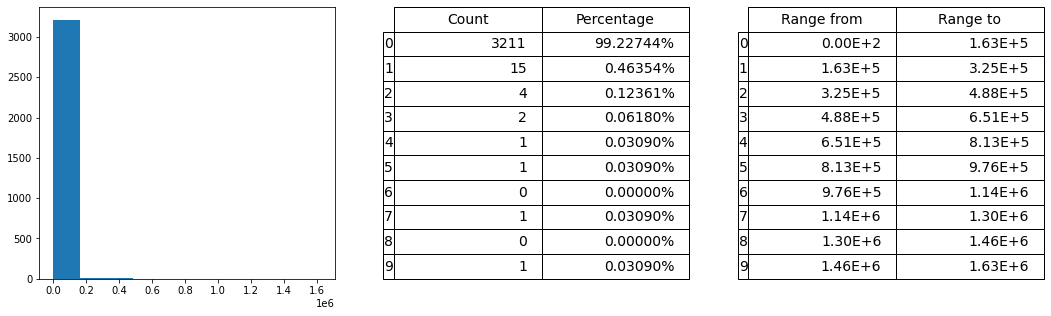

In [10]:
display_histogram(gb_videos, "comment_count")

Zdecydowana większość filmików ma mniej niż około 163 tysiące komentarzy.

#### Wyłączone komentarze

<AxesSubplot:>

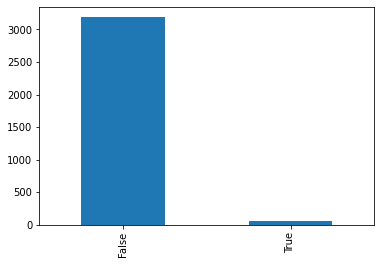

In [11]:
gb_videos["comments_disabled"].value_counts().plot.bar()

Większość filmików ma włączoną opcję zostawiania komentarzy przez użytkowników.

#### Wyłączone oceny

<AxesSubplot:>

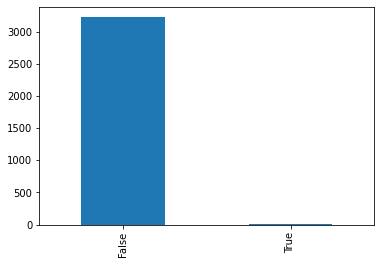

In [12]:
gb_videos["ratings_disabled"].value_counts().plot.bar()

Zdecydowana większość filmików ma włączoną opcję oceniania filmików.

#### Filmik ma błąd albo jest usunięty

<AxesSubplot:>

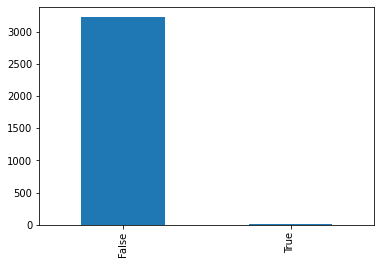

In [13]:
gb_videos["video_error_or_removed"].value_counts().plot.bar()

Bardzo mały odsetek filmików został usunięty albo miał błędy.

### Filmy z USA

#### Wyświetlenia

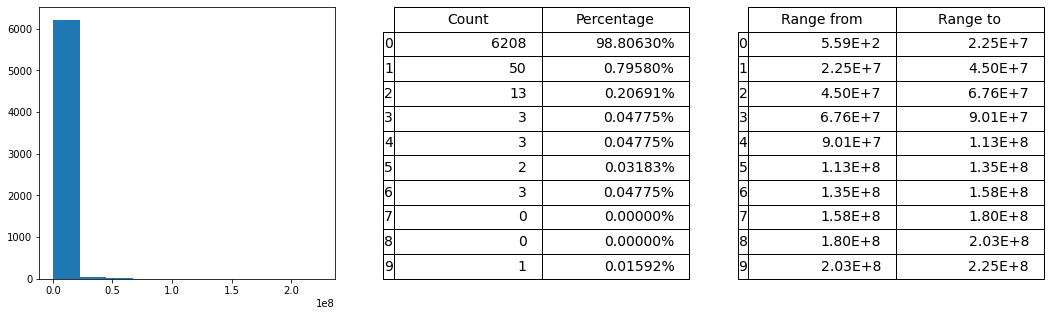

In [14]:
display_histogram(us_videos, "views")

Na przedstawionym wyżej histogramie widać, że zdecydowana większość filmików ma mniej niż 22.5 miliona wyświetleń.


#### Polubienia i negatywne oceny

##### Polubienia

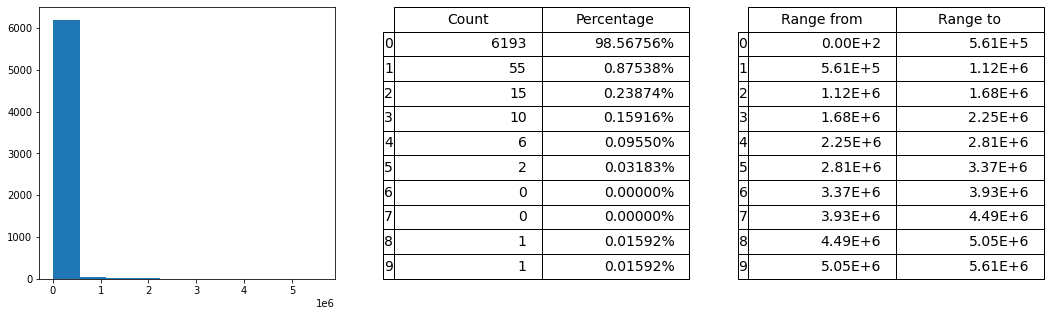

In [15]:
display_histogram(us_videos, "likes")

Większość filmików, podobnie jak w przypadku histogramu wyświetleń, trafia do pierwszego przedziału histogramu polubień - ponad 97% filmików ma mniej niż około 561 tysięcy polubień. Jest to najprawdopodobniej spowodowane przez rozkład wyświetleń filmików i mechanizm pozostawiania pozytywnej oceny. Aby ocenić filmik należy w niego wejść zwiększając tym samym liczbę wyświetleń. Sprawia to, że polubienia nigdy nie przekroczą liczby wyświetleń.

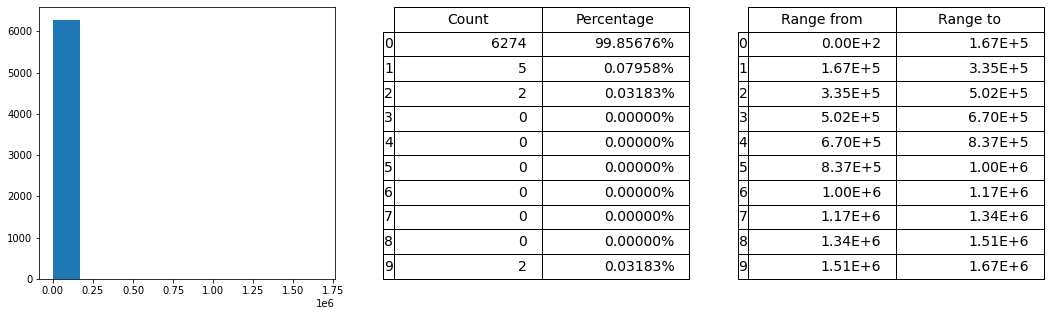

In [16]:
display_histogram(us_videos, "dislikes")

W przypadku negatywnych ocen otrzymany histogram jest jeszcze bardziej skupiony w pierwszym przedziale - ponad 99% filmików ma mniej niż 167 tysiący negatywnych ocen. Przyczyny takiego rozkładu są prawdopodobnie identyczne jak dla polubień, czyli wpływ na ten histogram mają rozkład wyświetleń filmików i mechanizm pozostawiania oceny.

#### Liczba komentarzy

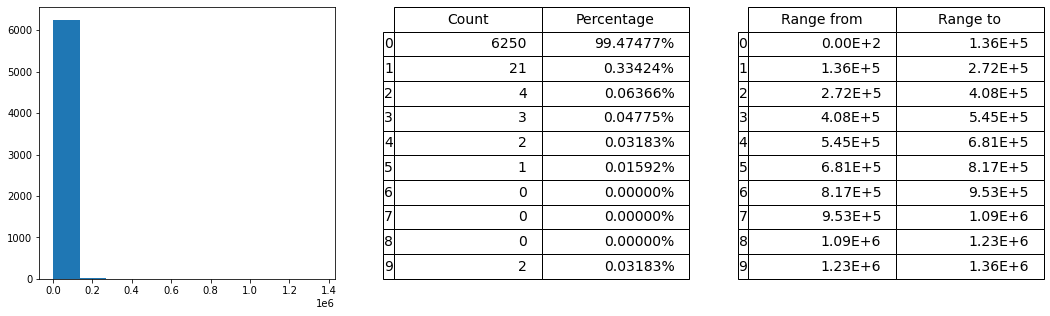

In [17]:
display_histogram(us_videos, "comment_count")

Zdecydowana większość filmików ma mniej niż 136 tysiący komentarzy.

#### Wyłączone komentarze

<AxesSubplot:>

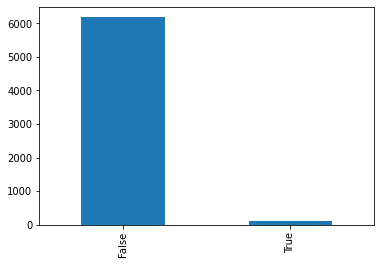

In [18]:
us_videos["comments_disabled"].value_counts().plot.bar()

Większość filmików ma włączoną opcję zostawiania komentarzy przez użytkowników.

#### Wyłączone oceny

<AxesSubplot:>

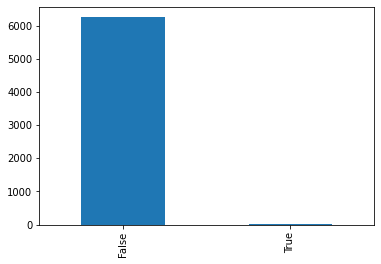

In [19]:
us_videos["ratings_disabled"].value_counts().plot.bar()

Zdecydowana większość filmików ma włączoną opcję oceniania filmików.

#### Filmik ma błąd albo jest usunięty

<AxesSubplot:>

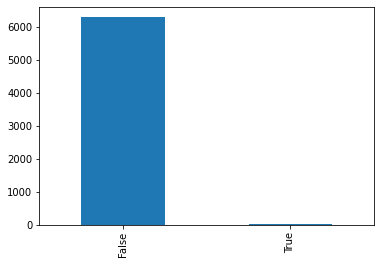

In [20]:
us_videos["video_error_or_removed"].value_counts().plot.bar()

Bardzo mały odsetek filmików został usunięty albo miał błędy.

### Inne wnioski

Kolumna category_id w obu zbiorach danych zawiera bardzo dużo braków. 

## Zmiana reprezentacji danych

Dane które będą używane do tworzenia atrybutów tekstowych to kolumny: 
- title
- channel_title
- tags
- views
- likes
- dislikes
- comment_count
- comments_disabled
- ratings disabled
- video_error_or_removed
- description

Z kolumn description i title atrybuty są tworzone na podstawie różnych cech tych ciągów znaków.

Atrybut video_id nie może zostać wykorzystany, ponieważ nie opisuje w żaden sposób filmu, a jest tylko przypadkowym ciągiem znaków. Data trending_date także nie ma większego znaczenia.

In [21]:
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've",
            "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of",
            "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "shan't", "she", "she'd",
            "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
            "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "until", "up", "very", "was", "wasn't", "we", "we'd",
            "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's",
            "which", "while", "who", "who's", "whom", "with", "would", "you", "you'd", "you'll", "you're", "you've",
            "your", "yours", "yourself", "yourselves", "above", "again", "against", "aren't", "below", "but", "can't",
            "cannot", "couldn't", "didn't", "doesn't", "don't", "down", "few", "hadn't", "hasn't", "haven't", "if",
            "isn't", "mustn't", "no", "nor", "not", "off", "out", "over", "shouldn't", "same", "too", "under", "why",
            "why's", "won't", "wouldn't"]

punctuation1 = "'*.,:;-_?!(){}[]<>|&’$‘+-=”“►▶/"
punctuation2 = ["``", "''", "...", "--", "'s"]

In [22]:
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text 

class SimpleTokenizer():
    @staticmethod
    def tokenize(text):
        return text.split(" ")
    
class NltkTokenizer():
    @staticmethod
    def tokenize(text):
        return nltk.word_tokenize(text) 
    
class Tokenizer():
    @staticmethod
    def tokenize(text):
        text = BeforeTokenizationNormalizer.normalize(text)
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            match = None
            if (RE_HASHTAG.search(token)) or (RE_EMOTICONS.search(token)) or (RE_HTTP.search(token)):
                match = True
            if match is not None:
                pass
            else:
                del tokens[i]
                tokens[i:i] = NltkTokenizer.tokenize(token)
            i += 1
            
        porter = nltk.PorterStemmer()
        for i in range(len(tokens)):
            tokens[i] = porter.stem(tokens[i])
            
        tokens1 = []
        for ii in tokens:
            if (ii not in stopwords) and (ii not in punctuation1) and (ii not in punctuation2):
                tokens1.append(ii)
        return tokens1


In [23]:
gb_videos["description"] = gb_videos["description "].apply(lambda row: str(row))
gb_videos["description_tokens"] = gb_videos["description"].apply(lambda row: Tokenizer.tokenize(row))
gb_videos["title_tokens"] = gb_videos["title"].apply(lambda row: Tokenizer.tokenize(row))
gb_videos["tags_tokens"] = gb_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [24]:
us_videos["description"] = us_videos["description "].apply(lambda row: str(row))
us_videos["description_tokens"] = us_videos["description"].apply(lambda row: Tokenizer.tokenize(row))
us_videos["title_tokens"] = us_videos["title"].apply(lambda row: Tokenizer.tokenize(row))
us_videos["tags_tokens"] = us_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [25]:
wordsTitleGB = Counter()
wordsDescriptionGB = Counter()
wordsTagsGB = Counter()

for i in gb_videos["title_tokens"]:
    wordsTitleGB.update(i)

for i in gb_videos["description_tokens"]:
    wordsDescriptionGB.update(i)

for i in gb_videos["tags_tokens"]:
    wordsTagsGB.update(i)

In [26]:
wordsTitleUS = Counter()
wordsDescriptionUS = Counter()
wordsTagsUS = Counter()

for i in us_videos["title_tokens"]:
    wordsTitleUS.update(i)

for i in us_videos["description_tokens"]:
    wordsDescriptionUS.update(i)

for i in us_videos["tags_tokens"]:
    wordsTagsUS.update(i)

Poniżej zbiór najczęściej występujących tokenów w tagach, opisach i tytułach. Najczęściej występujące tokeny mogą być brane jako atrybuty.

In [27]:
wordsTitleGB.most_common(30)

[('offici', 432),
 ('video', 338),
 ('trailer', 227),
 ('ft', 137),
 ('2018', 135),
 ('music', 127),
 ('new', 116),
 ('war', 108),
 ('live', 106),
 ('2017', 100),
 ('star', 95),
 ('audio', 94),
 ('hd', 89),
 ('trump', 83),
 ('last', 77),
 ('2', 71),
 ('feat', 71),
 ('talk', 71),
 ('vs', 68),
 ('movi', 63),
 ('(2018)', 61),
 ('day', 58),
 ('love', 58),
 ('1', 56),
 ('mv', 56),
 ('full', 56),
 ('christma', 55),
 ('perform', 55),
 ('jedi', 54),
 ('black', 52)]

In [28]:
wordsDescriptionGB.most_common(30)

[('video', 2059),
 ('show', 1431),
 ('thi', 1420),
 ('music', 1390),
 ('live', 1025),
 ('s', 995),
 ('new', 964),
 ('jimmi', 961),
 ('hi', 854),
 ('twitter', 844),
 ('late', 841),
 ('get', 765),
 ('youtub', 756),
 ('star', 753),
 ('channel', 751),
 ('instagram', 740),
 ('us', 738),
 ('facebook', 736),
 ('now', 681),
 ('offici', 651),
 ('can', 635),
 ('watch', 622),
 ('news', 616),
 ('like', 614),
 ('subscrib', 608),
 ('will', 592),
 ('one', 592),
 ('kimmel', 571),
 ('wa', 563),
 ('tmz', 559)]

In [29]:
wordsTagsGB.most_common(30)

[('funny', 380),
 ('comedy', 331),
 ('music', 266),
 ('[none]', 175),
 ('interview', 175),
 ('humor', 165),
 ('trailer', 155),
 ('video', 146),
 ('late night', 143),
 ('comedian', 140),
 ('pop', 140),
 ('celebrity', 139),
 ('talk show', 139),
 ('television', 134),
 ('celebrities', 128),
 ('live', 128),
 ('jokes', 127),
 ('funny video', 126),
 ('hollywood', 124),
 ('2018', 111),
 ('clip', 109),
 ('official', 109),
 ('rap', 109),
 ('hip hop', 107),
 ('famous', 103),
 ('show', 101),
 ('music video', 101),
 ('vlog', 99),
 ('star wars', 97),
 ('comedic', 95)]

In [30]:
wordsTitleUS.most_common(30)

[('offici', 487),
 ('video', 327),
 ('2018', 309),
 ('trailer', 303),
 ('vs', 177),
 ('2017', 175),
 ('new', 168),
 ('live', 167),
 ('make', 165),
 ('ft', 155),
 ('s', 153),
 ('first', 141),
 ('thi', 139),
 ('hd', 137),
 ('day', 131),
 ('music', 127),
 ('2', 126),
 ('game', 125),
 ('show', 122),
 ('get', 120),
 ('audio', 118),
 ('star', 117),
 ("n't", 110),
 ('whi', 110),
 ('war', 106),
 ('makeup', 104),
 ('hi', 100),
 ('movi', 98),
 ('tri', 96),
 ('world', 94)]

In [31]:
wordsDescriptionUS.most_common(30)

[('video', 5144),
 ('follow', 4304),
 ('thi', 4157),
 ('subscrib', 3427),
 ('twitter', 3308),
 ('facebook', 3027),
 ('instagram', 2949),
 ('watch', 2934),
 ('get', 2856),
 ('like', 2697),
 ('music', 2685),
 ('show', 2652),
 ('s', 2531),
 ('us', 2408),
 ('new', 2196),
 ('youtub', 1996),
 ('channel', 1885),
 ('live', 1677),
 ('news', 1637),
 ('jimmi', 1630),
 ('use', 1557),
 ('hi', 1503),
 ('make', 1483),
 ('late', 1437),
 ('can', 1419),
 ('»', 1415),
 ('product', 1398),
 ('wa', 1310),
 ('now', 1243),
 ('check', 1210)]

In [32]:
wordsTagsUS.most_common(30)

[('funny', 741),
 ('comedy', 657),
 ('humor', 282),
 ('music', 264),
 ('[none]', 257),
 ('interview', 238),
 ('comedian', 230),
 ('celebrity', 230),
 ('television', 229),
 ('news', 223),
 ('trailer', 221),
 ('celebrities', 216),
 ('talk show', 214),
 ('video', 214),
 ('how to', 210),
 ('late night', 198),
 ('2018', 197),
 ('funny video', 195),
 ('science', 193),
 ('pop', 192),
 ('live', 190),
 ('hollywood', 184),
 ('jokes', 184),
 ('food', 184),
 ('review', 180),
 ('nbc', 180),
 ('show', 174),
 ('clip', 162),
 ('entertainment', 161),
 ('sports', 156)]

In [33]:
AT_GB = gb_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_GB["title_length"] = gb_videos["title"].apply(lambda row: len(row))
AT_GB["title_uppercase"] = gb_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["title_emoticons"] = gb_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_GB["title_hashtag"] = gb_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_GB["title_interpunction"] = gb_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["description_length"] = gb_videos["description"].apply(lambda row: len(str(row)))
AT_GB["description_uppercase"] = gb_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["description_link"] = gb_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_GB["description_emoticons"] = gb_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_GB["description_hashtag"] = gb_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_GB["description_interpunction"] = gb_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["tag_number"] = gb_videos["tags"].apply(lambda row: len(row.split("|")))

display(AT_GB)

<ipython-input-33-a224da13f407>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_GB["title_length"] = gb_videos["title"].apply(lambda row: len(row))
<ipython-input-33-a224da13f407>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_GB["title_uppercase"] = gb_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
<ipython-input-33-a224da13f407>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,title_hashtag,title_interpunction,description_length,description_uppercase,description_link,description_emoticons,description_hashtag,description_interpunction,tag_number
video_id,,,,,,,,,,,,,,,,,,,
-3VBPAZPTQI,404690,16002,306,858,False,False,False,48,0.812500,False,False,2,4233,0.129931,True,True,False,456,13
-43MBOJnVks,1758599,16188,832,2182,False,False,False,33,0.727273,False,False,3,2952,0.078930,False,False,False,143,29
-5WBCrazSfg,345486,6810,121,688,False,False,False,70,0.114286,False,False,5,609,0.123153,True,True,False,47,30
-5aaJJQFvOg,1770509,163869,2704,7269,False,False,False,44,0.227273,False,False,3,751,0.113182,True,True,True,76,8
-7tSTUR7FG0,4651793,251125,1013,12150,False,False,False,33,0.303030,False,False,2,331,0.102719,True,True,False,40,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwEn-ambXLw,246809,8626,146,328,False,False,False,57,0.157895,False,False,1,509,0.029470,True,True,False,19,13
zwrlJwed2mQ,107312,763,3,26,False,False,False,60,0.333333,False,False,2,3103,0.073477,False,False,False,75,13
zxGg8QqWrRQ,124057,1981,98,347,False,False,False,89,0.213483,False,False,4,778,0.119537,True,True,False,74,32


In [34]:
AT_US = us_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_US["title_length"] = us_videos["title"].apply(lambda row: len(row))
AT_US["title_uppercase"] = us_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["title_emoticons"] = us_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_US["title_hashtag"] = us_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_US["title_interpunction"] = us_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["description_length"] = us_videos["description"].apply(lambda row: len(str(row)))
AT_US["description_uppercase"] = us_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["description_link"] = us_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_US["description_emoticons"] = us_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_US["description_hashtag"] = us_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_US["description_interpunction"] = us_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["tag_number"] = us_videos["tags"].apply(lambda row: len(row.split("|")))

display(AT_US)

<ipython-input-34-42a2e6040f72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_US["title_length"] = us_videos["title"].apply(lambda row: len(row))
<ipython-input-34-42a2e6040f72>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_US["title_uppercase"] = us_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
<ipython-input-34-42a2e6040f72>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,title_hashtag,title_interpunction,description_length,description_uppercase,description_link,description_emoticons,description_hashtag,description_interpunction,tag_number
video_id,,,,,,,,,,,,,,,,,,,
-0CMnp02rNY,800359,9773,332,423,False,False,False,74,0.121622,False,False,2,101,0.039604,False,False,False,3,33
-0NYY8cqdiQ,563746,4429,54,94,False,False,False,75,0.106667,False,False,2,244,0.045082,False,False,False,7,33
-1Hm41N0dUs,2058516,41248,580,1484,False,False,False,53,0.132075,False,False,1,2044,0.135519,True,True,False,127,23
-1yT-K3c6YI,231341,7734,212,846,False,False,False,51,0.764706,False,False,3,307,0.094463,True,True,True,23,8
-2RVw2_QyxQ,71089,460,27,20,False,False,False,30,0.100000,False,False,1,379,0.084433,False,False,False,19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwEn-ambXLw,241668,8478,144,328,False,False,False,57,0.157895,False,False,1,500,0.030000,True,True,False,19,13
zxUwbflE1SY,225280,5770,150,1312,False,False,False,52,0.134615,False,False,0,528,0.030303,True,True,True,64,10
zxwfDlhJIpw,8442986,166520,19462,48467,False,False,False,34,0.000000,False,False,1,4,0.250000,False,False,False,0,34


# Checkpoint 2

Importowanie bibliotek, funkcje pomocnicze i stałe

In [35]:
import urllib.request

RUN_REQUEST = False

def download_thumbnails(data, output_path):
    for video_id in data:
        try:
            urllib.request.urlretrieve("https://img.youtube.com/vi/" + video_id + "/0.jpg", output_path + video_id + ".jpg")
        except:
            print("Nie znaleziono " + video_id)

def makeArray(text):
    if text !="[]":
        return text.replace("'", "").replace("[", "").replace("]", "").split(", ")
    else:
        return []

Pobieranie thumbnail w większym rozmiarze

In [36]:
if RUN_REQUEST:
    download_thumbnails(gb_videos.index, "./data/thumbnails/GB/")

In [37]:
if RUN_REQUEST:
    download_thumbnails(us_videos.index, "./data/thumbnails/US/")

## OCR

Biblioteki, funkcje pomocnicze i stałe

In [38]:
from skimage import data, io, filters
import cv2
import pytesseract
import matplotlib.pyplot as plt
from IPython.display import clear_output

READ_CSV = True

### UK

In [39]:
if not READ_CSV:
    AG_GB = pd.DataFrame()

    lightRed = []
    lightGreen = []
    lightBlue = []
    sobelFilter = []
    text = []
    i=0
    for id in gb_videos.index:
        clear_output(wait=True)
        print("Processing text on images: "+str('%.2f'%(i/len(gb_videos)*100))+"%")
        i=i+1
        empty = False
        try:
            image = io.imread("./data/thumbnails/GB/"+id+".jpg")
            image = image[45:315,:,:]
        except:
            image = np.ones(270*480*3).reshape([270, 480, 3])
            empty = True
        lightRed.append(image[:,:,0].mean())
        lightGreen.append(image[:,:,1].mean())
        lightBlue.append(image[:,:,2].mean())
        sobelFilter.append(filters.sobel(image).mean())

        words = []
        if not empty:
            pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files (x86)/Tesseract-OCR/tesseract.exe'
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            thresh1 = cv2.adaptiveThreshold(gray.copy(),255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,251,-100)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 4))
            dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
            contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                            cv2.CHAIN_APPROX_NONE)
            im2 = image.copy()
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                if (w>20) and (h>20):
                    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    # Cropping the text block for giving input to OCR
                    cropped = thresh1[y:y + h, x:x + w]
                    detected_text = pytesseract.image_to_string(cropped)
                    if detected_text.replace("\n","").replace("  ","") not in [""," "]:
                        for token in Tokenizer.tokenize(detected_text):
                            if (len(token)>2) and (wordsDescriptionGB[token]>1):
                                words.append(token)
            #fig, ax = plt.subplots(2,2, figsize=(15,15))
            #ax[0,0].imshow(im2)
            #ax[0,1].imshow(gray, cmap=plt.get_cmap('gray'))
            #ax[1,0].imshow(thresh1, cmap=plt.get_cmap('gray'))
            #ax[1,1].imshow(dilation, cmap=plt.get_cmap('gray'))
            #plt.show()
        text.append(words)
        
    AG_GB["text"] = text
    AG_GB["lightRed"] = lightRed
    AG_GB["lightGreen"] = lightGreen
    AG_GB["lightBlue"] = lightBlue
    AG_GB["sobelFilter"] = sobelFilter

    AG_GB.to_csv("AG_GB.csv")  

In [40]:
if READ_CSV:
    AG_GB = pd.read_csv("AG_GB.csv", sep=',')
    AG_GB['text'] = AG_GB['text'].apply(makeArray)

In [41]:
counter = Counter()

for i in AG_GB["text"]:
    counter.update(i)

print(counter.most_common(30))

[('offici', 27), ('trailer', 22), ('vevo', 18), ('live', 16), ('news', 13), ('jimmi', 13), ('beatdown', 10), ('watch', 10), ('happen', 9), ('mum', 9), ('origin', 8), ('step', 6), ('2018', 5), ('new', 5), ('mark', 5), ('iii', 5), ('late', 5), ('review', 5), ('man', 5), ('channel', 4), ('game', 4), ('bag', 4), ('christma', 4), ('sieg', 4), ('music', 4), ('trump', 4), ('movi', 4), ('first', 4), ('full', 4), ('closer', 4)]


### USA

In [42]:
if not READ_CSV:
    AG_US = pd.DataFrame()

    lightRed = []
    lightGreen = []
    lightBlue = []
    sobelFilter = []
    text = []
    i=0
    for id in us_videos.index:
        clear_output(wait=True)
        print("Processing text on images: "+str('%.2f'%(i/len(us_videos)*100))+"%")
        i=i+1
        empty = False
        try:
            image = io.imread("./data/thumbnails/US/"+id+".jpg")
            image = image[45:315,:,:]
        except:
            image = np.ones(270*480*3).reshape([270, 480, 3])
            empty = True
        lightRed.append(image[:,:,0].mean())
        lightGreen.append(image[:,:,1].mean())
        lightBlue.append(image[:,:,2].mean())
        sobelFilter.append(filters.sobel(image).mean())

        words = []
        if not empty:
            pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files (x86)/Tesseract-OCR/tesseract.exe'
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            thresh1 = cv2.adaptiveThreshold(gray.copy(),255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,251,-100)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 4))
            dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
            contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                            cv2.CHAIN_APPROX_NONE)
            im2 = image.copy()
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                if (w>20) and (h>20):
                    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    # Cropping the text block for giving input to OCR
                    cropped = thresh1[y:y + h, x:x + w]
                    detected_text = pytesseract.image_to_string(cropped)
                    if detected_text.replace("\n","").replace("  ","") not in [""," "]:
                        for token in Tokenizer.tokenize(detected_text):
                            if (len(token)>2) and (wordsDescriptionUS[token]>1):
                                words.append(token)
            #fig, ax = plt.subplots(2,2, figsize=(15,15))
            #ax[0,0].imshow(im2)
            #ax[0,1].imshow(gray, cmap=plt.get_cmap('gray'))
            #ax[1,0].imshow(thresh1, cmap=plt.get_cmap('gray'))
            #ax[1,1].imshow(dilation, cmap=plt.get_cmap('gray'))
            #plt.show()
        text.append(words)
    AG_US["text"] = text
    AG_US["lightRed"] = lightRed
    AG_US["lightGreen"] = lightGreen
    AG_US["lightBlue"] = lightBlue
    AG_US["sobelFilter"] = sobelFilter

    AG_US.to_csv("AG_US.csv")  

In [43]:
if READ_CSV:
    AG_US = pd.read_csv("AG_US.csv", sep=',')
    AG_US['text'] =AG_US['text'].apply(makeArray)

In [44]:
counter = Counter()

for i in AG_US["text"]:
    counter.update(i)

print(counter.most_common(30))

[('news', 37), ('offici', 36), ('origin', 35), ('jimmi', 29), ('trailer', 27), ('first', 26), ('watch', 24), ('happen', 23), ('vevo', 23), ('movi', 19), ('live', 18), ('nbc', 15), ('blank', 14), ('step', 14), ('talk', 12), ('highlight', 11), ('ate', 10), ('mum', 9), ('whi', 9), ('top', 9), ('ever', 8), ('everyth', 8), ('gmm', 7), ('lip', 7), ('teaser', 7), ('day', 7), ('iii', 7), ('christma', 6), ('make', 6), ('mar', 6)]


## Klasyfikacja

Biblioteki, funkcje pomocnicze, wspólne zmienne i stałe

In [45]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tqdm.auto import tqdm

model = ResNet50(weights='imagenet')

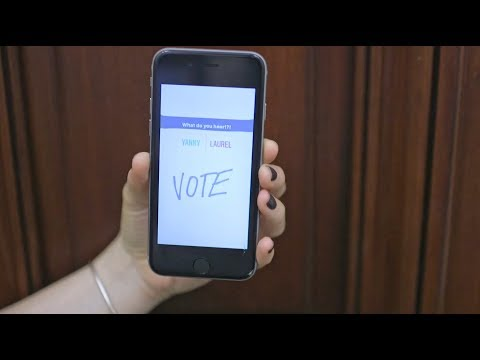

Predicted: [('n03584254', 'iPod', 0.64892924), ('n02992529', 'cellular_telephone', 0.18888845), ('n03777754', 'modem', 0.02961525), ('n03485407', 'hand-held_computer', 0.027228469), ('n06359193', 'web_site', 0.014069771)]


In [66]:
from IPython.display import Image, display

img_path = "data/thumbnails/GB/1qsRU7C_Gp0.jpg"

display(Image(filename=img_path))

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=5)[0])

### UK

In [47]:
results = []
no_load = 0

for id in tqdm(gb_videos.index):
    try:
        img = image.load_img("./data/thumbnails/GB/" + id + ".jpg", target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        decoded = decode_predictions(preds, top=1)[0]
        decoded = [x[1] for x in decoded]
        results.append(decoded[0])
    except:
        no_load = no_load + 1
        results.append("")

AG_GB["thumbnailDescription"] = results

print("Couldn't open {} files".format(no_load))

  0%|          | 0/3236 [00:00<?, ?it/s]

Couldn't open 387 files


In [48]:
AG_GB.head()

,Unnamed: 0,text,lightRed,lightGreen,lightBlue,sobelFilter,thumbnailDescription
0,0,[],156.558611,123.349884,109.113758,0.084025,lipstick
1,1,[],124.824082,123.233727,118.124275,0.035754,television
2,2,[],111.618156,107.661481,95.612569,0.078878,web_site
3,3,[],138.034213,103.151991,116.714938,0.088099,television
4,4,[],152.275309,152.125100,153.678511,0.034287,mountain_bike


In [70]:
data = AG_GB["thumbnailDescription"].values.tolist()

counter = Counter()

for x in data:
    counter.update({x: 1})

counter.most_common(50)

[('television', 1096),
 ('web_site', 632),
 ('', 387),
 ('monitor', 67),
 ('theater_curtain', 52),
 ('groom', 51),
 ('sax', 47),
 ('comic_book', 46),
 ('microphone', 31),
 ('stage', 28),
 ('wig', 26),
 ('abaya', 23),
 ('book_jacket', 21),
 ('home_theater', 21),
 ('scoreboard', 17),
 ('sunglasses', 17),
 ('barbershop', 15),
 ('screen', 15),
 ('suit', 14),
 ('Windsor_tie', 14),
 ('bow_tie', 14),
 ('mountain_bike', 13),
 ('cellular_telephone', 11),
 ('lipstick', 10),
 ('envelope', 10),
 ('fountain', 9),
 ('spotlight', 9),
 ('lab_coat', 9),
 ('digital_clock', 9),
 ('street_sign', 9),
 ('cash_machine', 8),
 ('bubble', 7),
 ('cinema', 7),
 ('jersey', 7),
 ('hair_spray', 7),
 ('bannister', 7),
 ('brassiere', 6),
 ('mask', 6),
 ('marimba', 6),
 ('window_shade', 6),
 ('electric_guitar', 6),
 ('chain_mail', 6),
 ('washbasin', 6),
 ('syringe', 6),
 ('cloak', 6),
 ('dumbbell', 5),
 ('feather_boa', 5),
 ('fur_coat', 5),
 ('candle', 5),
 ('ice_lolly', 5)]

### USA

In [49]:
results = []
no_load = 0

for id in tqdm(us_videos.index):
    try:
        img = image.load_img("./data/thumbnails/US/" + id +".jpg", target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        decoded = decode_predictions(preds, top=1)[0]
        decoded = [x[1] for x in decoded]
        results.append(decoded[0])
    except:
        no_load = no_load + 1
        results.append("")

AG_US["thumbnailDescription"] = results

print("Couldn't open {} files".format(no_load))

  0%|          | 0/6283 [00:00<?, ?it/s]

Couldn't open 488 files


In [50]:
AG_US.head()

,Unnamed: 0,text,lightRed,lightGreen,lightBlue,sobelFilter,thumbnailDescription
0,0,[],120.631852,125.198580,133.230401,0.110362,television
1,1,[],130.378434,137.141698,145.877693,0.109129,television
2,2,[],116.568981,95.533148,90.406427,0.066549,envelope
3,3,[],164.492492,133.028256,134.954360,0.120691,web_site
4,4,[showdown],121.184074,137.213140,149.353364,0.095754,web_site


In [71]:
data = AG_US["thumbnailDescription"].values.tolist()

counter = Counter()

for x in data:
    counter.update({x: 1})

counter.most_common(50)

[('television', 1950),
 ('web_site', 1269),
 ('', 488),
 ('monitor', 146),
 ('groom', 115),
 ('comic_book', 102),
 ('theater_curtain', 61),
 ('abaya', 53),
 ('stage', 50),
 ('sax', 48),
 ('wig', 40),
 ('microphone', 40),
 ('lipstick', 38),
 ('home_theater', 33),
 ('barbershop', 33),
 ('street_sign', 32),
 ('book_jacket', 32),
 ('envelope', 28),
 ('screen', 28),
 ('scoreboard', 27),
 ('suit', 26),
 ('corn', 23),
 ('digital_clock', 23),
 ('football_helmet', 23),
 ('bannister', 21),
 ('volcano', 21),
 ('sunglasses', 20),
 ('bow_tie', 19),
 ('bakery', 19),
 ('fountain', 18),
 ('syringe', 16),
 ('cellular_telephone', 15),
 ('lab_coat', 15),
 ('kimono', 15),
 ('bubble', 15),
 ('hair_spray', 14),
 ('Windsor_tie', 14),
 ('oscilloscope', 13),
 ('candle', 13),
 ('electric_guitar', 13),
 ('cash_machine', 13),
 ('ice_lolly', 12),
 ('jersey', 12),
 ('basketball', 12),
 ('cinema', 12),
 ('ski', 11),
 ('bookshop', 11),
 ('lighter', 11),
 ('spotlight', 11),
 ('feather_boa', 10)]